In [1]:
import pdb
import time
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# 0. Data
 - [Scenario10](https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/)
     - Infected IPs = [147.32.84.165, 147.32.84.191, 147.32.84.192, 147.32.84.193, 147.32.84.204, 147.32.84.205, 147.32.84.206, 147.32.84.207, 147.32.84.208, 147.32.84.209]

In [2]:
def getData(filename):
    t0 = time.time()
    if (1):
        cols = ['date', 'time', 'duration', 'protocol', 'src', 'direction', 'dst', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']
        df   = pd.read_csv(filename, skiprows=1, header=0, sep='\s+',names=cols)
    else:
        cols = ['date', 'time', 'duration', 'protocol', 'src', 'direction', 'dst', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label', 'labels']
        df   = pd.read_csv(filename, skiprows=1, header=0, sep='\s+',names=cols)
    print (' - Dataframe read. Pre-processing now... ({0}s)'.format(round(time.time() - t0,2)))
    return df

def processData(df):
    # Step1 - Clean out NaN values
    df                           = df.fillna(0)
    
    # Step2 - Remove background labels
    df                           = df[df['label'] != 'Background']
    print (' - Total len : ', len(df), ' (w/0 background and w/0 NaN)')
    
    if (not df.isnull().values.any()):
        
        # Step3 - Index of Columns
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df             = df.set_index(df['datetime'])
        
        # Step4 - Column String Formatting
        df['src_ip'], df['src_port'] = df['src'].str.split(':', 1).str
        df['dst_ip'], df['dst_port'] = df['dst'].str.split(':', 1).str
        
        # Step5 - Codify columns
        df['src_ip_num']             = pd.Categorical(df['src_ip'], categories=df['src_ip'].unique()).codes
        df['dst_ip_num']             = pd.Categorical(df['dst_ip'], categories=df['dst_ip'].unique()).codes
        df['protocol_num']           = pd.Categorical(df['protocol'], categories=df['protocol'].unique()).codes
        df['flags_num']              = pd.Categorical(df['flags'], categories=df['flags'].unique()).codes
        
        # Step6 - Casting of columns
        df['packets'] = df['packets'].astype(int)
        df['bytes']  = df['bytes'].astype(int)
        
        # Stp7 - Drop Columns
        df.drop('src', axis=1, inplace=True)
        df.drop('dst', axis=1, inplace=True)
        df.drop('direction', axis=1, inplace=True)
        # df.drop('tos', axis=1, inplace=True)
        df.drop('flows', axis=1, inplace=True)
        df.drop('flags', axis=1, inplace=True)
        df.drop('date', axis=1, inplace=True)
        df.drop('time', axis=1, inplace=True)
        df.drop('datetime', axis=1, inplace=True)
        
        tmp = df.columns.tolist()
        tmp.remove('label')
        df  = df[tmp + ['label']]
        
        df.sort_index(inplace=True)
        df.reset_index(inplace=True)
        
        print (' - label : ', Counter(df['label']))
        for label_ in df['label'].unique():
            unique_vals = df[df['label'] == label_]['src_ip'].unique()
            print (' - Label : ', label_, ' || Unique IPs : ', len(unique_vals))
        
    else:
        print (' - NAN detected!')
        
    return df

    
    
    return df

if __name__ == "__main__":
    df_scene10_raw = getData('data/capture20110818.pcap.netflow.labeled')
    df_scene10     = processData(df_scene10_raw) 
    display(df_scene10.head(n=5))
    
    df_infected  =  df_scene10[df_scene10['label'] == 'Botnet']
    df_normal      = df_scene10[df_scene10['label'] == 'LEGITIMATE']
    
    ips_normal    = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']
    ips_infected  = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209', '147.32.84.204']
    IP_INFECTED_STUDY = '147.32.84.191'

 - Dataframe read. Pre-processing now... (11.76s)
 - Total len :  645358  (w/0 background and w/0 NaN)
 - label :  Counter({'Botnet': 323441, 'LEGITIMATE': 321917})
 - Label :  LEGITIMATE  || Unique IPs :  471
 - Label :  Botnet  || Unique IPs :  67


,datetime,duration,protocol,tos,packets,bytes,src_ip,src_port,dst_ip,dst_port,src_ip_num,dst_ip_num,protocol_num,flags_num,label
0,2011-08-18 10:19:13.347,4.985,TCP,0,91,86277,147.32.80.13,80,147.32.85.88,56949,0,0,0,0,LEGITIMATE
1,2011-08-18 10:19:13.392,0.000,TCP,0,1,66,147.32.86.110,48102,74.125.232.214,443,1,1,0,1,LEGITIMATE
2,2011-08-18 10:19:13.411,4.921,TCP,0,49,3234,147.32.85.88,56949,147.32.80.13,80,2,2,0,1,LEGITIMATE
3,2011-08-18 10:19:13.460,4.742,TCP,0,118,7080,147.32.84.59,2768,74.125.108.208,80,3,3,0,1,LEGITIMATE
4,2011-08-18 10:19:13.486,0.000,TCP,0,1,60,147.32.84.59,56058,74.125.232.215,443,3,4,0,1,LEGITIMATE


# 1. Task1 - Analyze
- Select 2 features to discretize. Features can be selected using visualizations.
- Combine them using the mandated technique

## 1.2 Analyze IPs

 - Task : Here we analyze the features of one infected and one normal IP (via histograms)
 - Conclusion1 : Protocol is a good discriminative feature as can be seen from the bar plots
 - Conclusion2 : Byte size is also a discriminative feature as can be seen in the bar plots

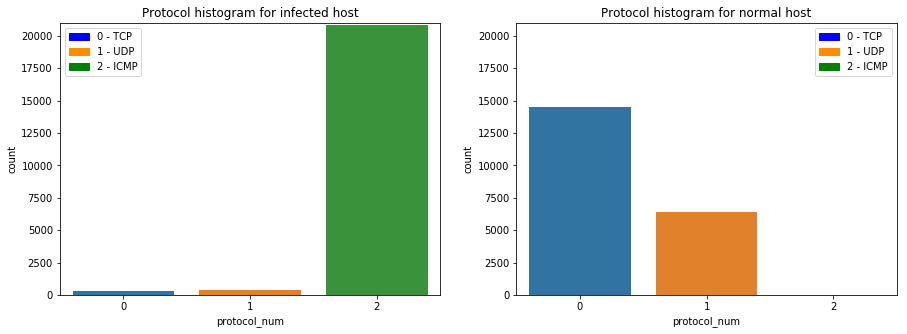

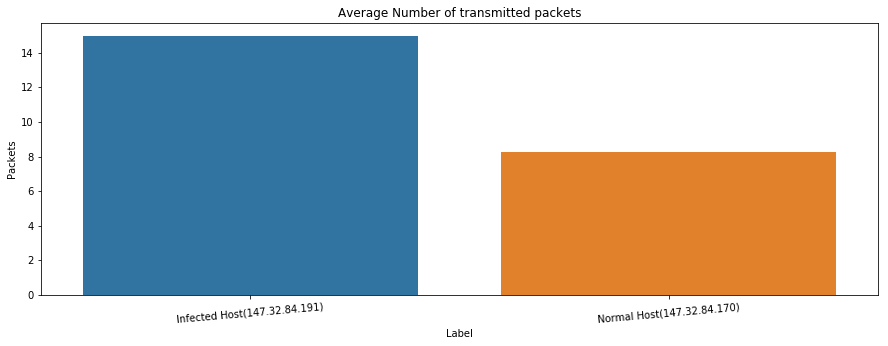

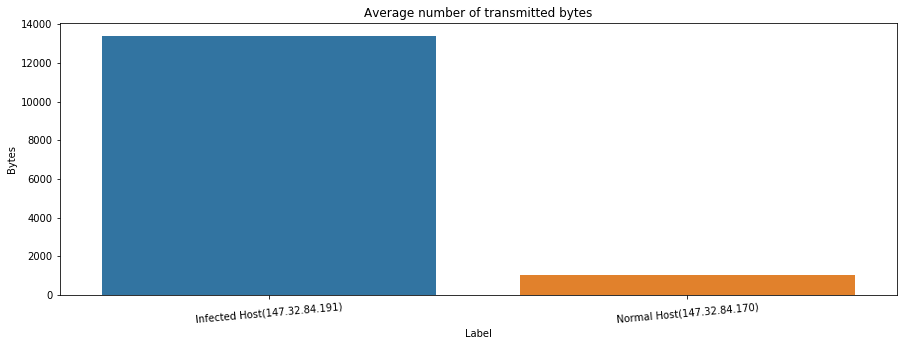

In [28]:
def analyze_protocol(df_infected, df_normal, ip_infected, ip_normal):
    f, axarr = plt.subplots(1,2, figsize=(15,5))
    sns.countplot(x='protocol_num', data = df_infected[df_infected['src_ip'] == ip_infected], ax=axarr[0])
    orange_patch = mpatches.Patch(color='darkorange', label='1 - UDP')
    blue_patch   = mpatches.Patch(color='blue', label='0 - TCP')
    green_patch  = mpatches.Patch(color='green', label='2 - ICMP')
    axarr[0].set_title('Protocol histogram for infected host')
    axarr[0].legend(handles=[blue_patch, orange_patch, green_patch])
    axarr[0].set_ylim(0,21000)

    sns.countplot(x='protocol_num', data = df_normal[df_normal['src_ip'] == ip_normal], ax=axarr[1])
    orange_patch = mpatches.Patch(color='darkorange', label='1 - UDP')
    blue_patch   = mpatches.Patch(color='blue', label='0 - TCP')
    green_patch  = mpatches.Patch(color='green', label='2 - ICMP')
    axarr[1].set_title('Protocol histogram for normal host')
    axarr[1].legend(handles=[blue_patch, orange_patch, green_patch])
    axarr[1].set_ylim(0,21000)
    plt.show()

def analyze_packets_bytes(df_infected, df_normal, ip_infected, ip_normal):

    Packets = []
    Bytes = []
    
    if (1):
        df_infected_host = df_infected[df_infected['src_ip'] == ip_infected]
        Packets.append(df_infected_host.packets.mean())
        Bytes.append(df_infected_host.bytes.mean())

        df_normal_host = df_normal.loc[(df_normal['src_ip'] == ip_normal)]
        Packets.append(df_normal_host.packets.mean())
        Bytes.append(df_normal_host.bytes.mean())
    
    if (1):
        labels = ('Infected Host({})'.format(ip_infected) , 'Normal Host({})'.format(ip_normal))
        df_packets = {'Label': labels, 'Packets': Packets }
        df_bytes = {'Label': labels, 'Bytes': Bytes }
        df_packets = pd.DataFrame(df_packets)
        df_bytes = pd.DataFrame(df_bytes)

    plt.figure(figsize = (15,5))
    plt.title('Average Number of transmitted packets')
    plt.xticks(rotation=5)
    sns.barplot(x='Label', y = 'Packets', data= df_packets)

    plt.figure(figsize = (15,5))
    plt.title('Average number of transmitted bytes')
    plt.xticks(rotation=5)
    sns.barplot(x='Label', y = 'Bytes', data= df_bytes)
    
    plt.show()

if __name__ == "__main__":
    ips_normal    = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']
    analyze_protocol(df_infected, df_normal, ip_infected=IP_INFECTED_STUDY, ip_normal='147.32.84.170')
    analyze_packets_bytes(df_infected, df_normal, IP_INFECTED_STUDY, ip_normal='147.32.84.170')

# Task2 - Discretization
 - Discretization of flow data

In [11]:
# Class to discretize categorical variables
class Discretize_cat:

    def __init__(self, df, featname, verbose=0):
        self.s        = len(df[featname].unique())
        self.featname = featname
        self.df       = df
        if verbose:
            print (' - featname : ', featname, ' || Unique : ', df[featname].unique())
            print ('')
    
    def size(self): # return the size |M_i|
        return self.s

    def val(self, row): # return the value M_i
        return row[self.featname]

# Class to discretize numerical variables
class Discretize_num:

    def __init__(self, df, featname, verbose=0):
        self.bins            = 5
        self.percentiles     = list(range(100//self.bins, 100, 100//self.bins))
        self.percentiles[-1] = 100
        self.percentile_vals = np.percentile(df[featname].values, self.percentiles)
        self.s               = len(self.percentiles)
        self.featname        = featname
        self.df              = df
        if verbose:
            plt.plot(df[featname].values); plt.show()
            print (' - feat : ', featname, ' || percentiles :  ', self.percentiles)
            print (' - feat : ', featname, ' || percentile_vals : ', self.percentile_vals)
            print ('')

    def size(self): # return the size |M_i|
        return self.s

    def val(self, row): # return the value M_i
        val = row[self.featname]
        prev = 0
        for i, cur in enumerate(self.percentile_vals):
            if val >= prev and val < cur:
                return i
            prev = cur
        return 0
    
# encode a single flow 
def encode_flow(feats, row, verbose=0):
    code       = 0
    space_size = 1
    for feat in feats:
        space_size *= feats[feat].size()
    for feat in feats: 
        featObj = feats[feat]
        s = featObj.size()
        v = featObj.val(row)
        code += v * (space_size / s)
        space_size = space_size / s
        if verbose:
            print (' - feat : ',featObj.featname,' - row : ', row[featObj.featname], ' || v : ', v, ' || code : ', code)
    if verbose:
        print (' ---- code : ', code)
        pdb.set_trace()
        
    return code

# encode an entire series of flows
def encode_series(df, feats):
    encoded = []
    for index, row in df.iterrows():
        encoded.append(encode_flow(feats, row))
    return encoded

## 2.1 Plotting the discretized feature

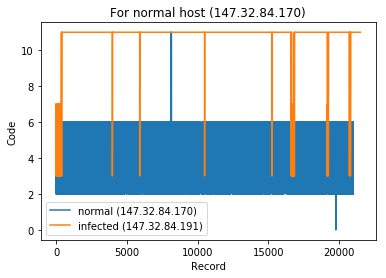

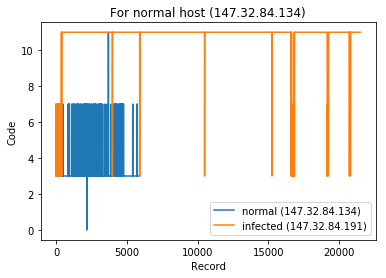

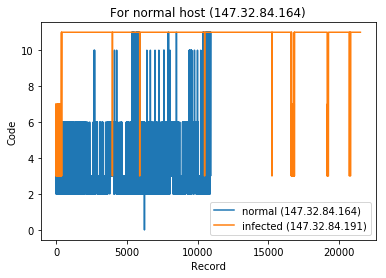

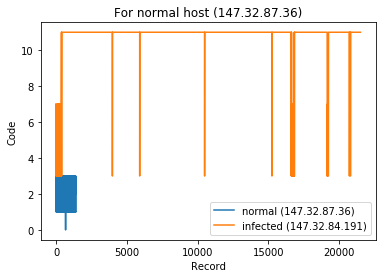

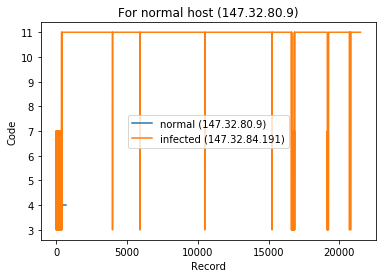

In [12]:
# Comparing each normal host with the infected host with the discretization applied on protocol_num and packets

# the list of normal ips without normal host6 since it does not appear as the src_ip in the dataset
ip_normal_new = ip_normal[0:5]


# Displaying the discretized value for each normal host in conjunction with the infected host.
for normal_host in ip_normal_new:
    normal_one_host = df_scene10.loc[(df_scene10['src_ip'] == normal_host)]
    feats = {'protocol_num': Discretize_cat(normal_one_host, 'protocol_num'), 'packets': Discretize_num(normal_one_host, 'packets')}
    plt.plot(encode_series(normal_one_host, feats), label='normal ({})'.format(normal_host))
    feats = {'protocol_num': Discretize_cat(df_infected, 'protocol_num'), 'packets': Discretize_num(df_infected, 'packets')}
    plt.plot(encode_series(df_infected, feats), label='infected ({})'.format(infected_host))

    plt.xlabel('Record')
    plt.ylabel('Code')
    plt.title('For normal host ({})'.format(normal_host))
    plt.legend()
    plt.show()

The above visualizations indicate that using discretization as given in Paper 4(Learning Behavioral Fingerprints From Netflows
Using Timed Automata), is useful in discerning between normal and infected netflows. 